In [17]:
from torchvision import models
import torch
resnet101 = models.resnet101(pretrained = True)
from torchvision import transforms
imgtransform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225])])

In [34]:
from PIL import Image
sampleimage = Image.open("boat.jpg")

In [35]:
image_t = imgtransform(sampleimage)
batch = torch.unsqueeze(image_t,0)

In [36]:
resnet101.eval();

In [46]:
with open('imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]
output = resnet101(batch)
_, indices = torch.sort(output, descending=True)
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
[(classes[idx], percentage[idx].item()) for idx in indices[0][:5]]
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
  net = models.resnet101();
  macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True);
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

ResNet(
  44.549 M, 100.000% Params, 7.85 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.009 M, 0.021% Params, 0.118 GMac, 1.503% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(0.0 M, 0.000% Params, 0.002 GMac, 0.020% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0.0 M, 0.000% Params, 0.001 GMac, 0.010% MACs, inplace=True)
  (maxpool): MaxPool2d(0.0 M, 0.000% Params, 0.001 GMac, 0.010% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    0.216 M, 0.484% Params, 0.68 GMac, 8.668% MACs, 
    (0): Bottleneck(
      0.075 M, 0.168% Params, 0.236 GMac, 3.012% MACs, 
      (conv1): Conv2d(0.004 M, 0.009% Params, 0.013 GMac, 0.164% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(0.0 M, 0.000% Params, 0.0 GMac, 0.005% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(0.037 M, 0.0

### 

In [39]:
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [40]:
netG = ResNetGenerator()
model_path = 'horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)
netG.eval();

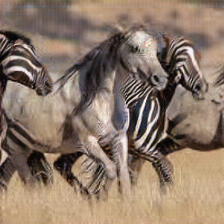

In [45]:
imgtransform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225])])
sampleimage = Image.open("horse5.jpg")
image_t = imgtransform(sampleimage)
batch = torch.unsqueeze(image_t,0)
batchout = netG(batch)
imageout = (batchout.data.squeeze()+1)/2
finalimage = transforms.ToPILImage()(imageout)
finalimage

In [9]:
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
  net = ResNetGenerator()
  macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

ResNetGenerator(
  11.378 M, 100.000% Params, 43.555 GMac, 100.000% MACs, 
  (model): Sequential(
    11.378 M, 100.000% Params, 43.555 GMac, 100.000% MACs, 
    (0): ReflectionPad2d(0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, (3, 3, 3, 3))
    (1): Conv2d(0.009 M, 0.083% Params, 0.475 GMac, 1.091% MACs, 3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(0.0 M, 0.000% Params, 0.003 GMac, 0.007% MACs, 64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(0.0 M, 0.000% Params, 0.003 GMac, 0.007% MACs, inplace=True)
    (4): Conv2d(0.074 M, 0.649% Params, 0.926 GMac, 2.127% MACs, 64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(0.0 M, 0.000% Params, 0.002 GMac, 0.004% MACs, 128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(0.0 M, 0.000% Params, 0.002 GMac, 0.004% MACs, inplace=True)
    (7): Conv2d(0.295 M, 2.594% Params, 0.926 GMac, 2.125% MACs, 128, 256, kernel_size=(3, 3)

In [51]:
dir(models)
mobilenetv2 = models.mobilenet_v2(pretrained = True)
from torchvision import transforms
imgtransform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225])])
mobilenetv2.eval();
from PIL import Image
sampleimage = Image.open("boat.jpg")
image_t = imgtransform(sampleimage)
batch = torch.unsqueeze(image_t,0)
with open('imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]
output = mobilenetv2(batch)
_, indices = torch.sort(output, descending=True)
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
[(classes[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('speedboat', 63.66163635253906),
 ('gondola', 21.458023071289062),
 ('canoe', 2.5368568897247314),
 ('seashore, coast, seacoast, sea-coast', 1.9517611265182495),
 ('catamaran', 1.79120934009552)]

In [11]:
with torch.cuda.device(0):
  net = models.mobilenet_v2()
  macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

MobileNetV2(
  3.505 M, 100.000% Params, 0.32 GMac, 100.000% MACs, 
  (features): Sequential(
    2.224 M, 63.451% Params, 0.319 GMac, 99.600% MACs, 
    (0): ConvNormActivation(
      0.001 M, 0.026% Params, 0.012 GMac, 3.760% MACs, 
      (0): Conv2d(0.001 M, 0.025% Params, 0.011 GMac, 3.384% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(0.0 M, 0.002% Params, 0.001 GMac, 0.251% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(0.0 M, 0.000% Params, 0.0 GMac, 0.125% MACs, inplace=True)
    )
    (1): InvertedResidual(
      0.001 M, 0.026% Params, 0.012 GMac, 3.635% MACs, 
      (conv): Sequential(
        0.001 M, 0.026% Params, 0.012 GMac, 3.635% MACs, 
        (0): ConvNormActivation(
          0.0 M, 0.010% Params, 0.005 GMac, 1.504% MACs, 
          (0): Conv2d(0.0 M, 0.008% Params, 0.004 GMac, 1.128% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)